Prière de bien run setup.py au cas où le dossier DeepPDE n'est pas reconnu étant comme un package.


Il faut aussi installer numpy==1.19 et tensorflow==2.3.0

Nous avons assainir l'environnement en créant des classes à partir des focntions écrites et en regrouper avec celles qui existent.

### Problem Formulation
The option price u solves the multivariate Black-Scholes partial differential equation (formulated in the log-price with t being the time to maturity):

$$
\partial_t u + 
  r  u 
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u 
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u 
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u  
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u = 0
$$

with the payoff as initial conditions

$
u(t=0) = \max(0, (e^{x_1} + e^{x_2})/2 - K).
$

We can reformulate any option as one with strike price $K=100$, so we keep it fixed.  

 ### Deep Parametric PDE Method

The deep parametric PDE method trains a neural network unsupervised to approximate the option price for all values of $t$, $x$ and the option parameters $r, \sigma_1, \sigma_2, \rho$ (collected in the parameter vector $\mu$):

$ u_{\rm{DNN}}(t, x, \mu) \approx  u(t, x, \mu) $.



In [67]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import urllib
import os

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

#Classes créees et regroupées 
from DeepPDE.Classes.DPDEGenerator  import DPDEGenerator
from DeepPDE.Classes.DPEDEModel  import DPDEModel
from DeepPDE.Classes.HighwayLayer import *
from DeepPDE.tools.others import *

np.random.seed(42)


## Paramètre de l'utilisateur


*Load* est une variable booléene dont sa valeur **True** permet de charger le modèle pré entrainé des auteurs et **False** permet 
d'entrainer notre propre modèle. 
*nr_samples_surface_plot* : Nombres de points dans chaque direction utilisés pour les graphiques de surface variant les prix des actifs des sous-jacents.
*nr_samples_scatter_plot* : Nombre de points aléatoires (variant le temps, le prix de l'actif et les paramètres de l'option) utilisés pour les diagrammes de dispersion ci-dessous.

*nr_samples_error_calculation* : Nombre de points aléatoires utilisés ci-dessous pour approximer l'erreur 


In [68]:

load_model = False
nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000

We define parameters value born for normalizing 

In [69]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.

## Paramètres du réseau 

Paramètres concernant la taille et l'entraînement du réseau neuronal. 

Procéder à un nouvel entraînement après toute modification.

In [70]:
nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 100
nr_epochs = 601

In [71]:
dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter

t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1


### we initiate the class *Tranform* with its constructor by parameters

In [72]:

normalise =Transform(0,t_max=t_max, strike_price=strike,volatility_min= volatility_min,
                     volatility_max= volatility_max,normalise_min=normalised_min,normalise_max=normalised_max,r_min=riskfree_rate_min,
                     r_max= riskfree_rate_max,rho_min= correlation_min,rho_max= correlation_max)


With the function *create_network* in *Classes/Highwalayer.py*,
we create the network with three highway layers and the additional localisation:
$$
10 \log( 1 + e^{0.1((e^{x_1} + e^{x_2})/2 - K e^{-rt})})
$$


In *Classes/DPDEGenerator.py*, it is created creates batches of random points in the computational domain to evaluate and train the loss function at. 

It creates
 * Points in the interior $(t^i, x^i, \mu^i)$  as data_train_interior
 * Points at the payoff $(0, \hat x^i \hat \mu^i)$ as data_train_initial

In Classes/DPEDEModel.py, the Keras model constructs the PDE-based residual for the training. 

$\mathcal{J}(u) = \mathcal{J}_{\rm{int}}(u) + \mathcal{J}_{\rm{ic}}(u)$,

with the residual of the PDE

$\mathcal{J}_{\rm{int}}(u) = $
$\sum_{i=1}^N$
\left(\partial_t u(t^i, x^i, \mu^i) + 
  r  u 
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u (t^i, x^i, \mu^i)
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u (t^i, x^i, \mu^i)
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  (t^i, x^i, \mu^i)
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u (t^i, x^i, \mu^i) 
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u(t^i, x^i, \mu^i) \right)^2
$

and the mean-squared error of the initial condition:

$
\mathcal{J}_{\rm{ic}}(u) =\sum_{i=1}^N \left(u(0, \hat x^i, \hat \mu^i) -  \max(0, (e^{\hat x_1^i} + e^{\hat x_2^i})/2 - K)\right)^2.
$

As all variables were normalised, they and their derivatives need to be transformed.

## Train or load Model

In [86]:
%%time
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
        inputs = keras.Input(shape=(dimension_total,)) #inputs for the first layer
        outputs = create_network(inputs, nr_nodes_per_layer=nr_nodes_per_layer, localisation_parameter=localisation_parameter, dimension_total=7)
        model = DPDEModel(inputs=inputs, outputs=outputs)
        batch_generator = DPDEGenerator(n_train, normalised_min=normalised_min, normalised_max=normalised_min, dimension_states=2, dimension_param=4)
        model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
        callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
        model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,callbacks=[callback])

Epoch 1/601
10/10 [==============================] - 1s 73ms/step - loss: 0.0060 - loss initial: 0.0040 - loss interior: 0.0020
Epoch 2/601
10/10 [==============================] - 1s 62ms/step - loss: 0.0011 - loss initial: 8.9497e-04 - loss interior: 2.1001e-04
Epoch 3/601
10/10 [==============================] - 0s 47ms/step - loss: 3.3339e-04 - loss initial: 3.0369e-04 - loss interior: 2.9701e-05
Epoch 4/601
10/10 [==============================] - 0s 48ms/step - loss: 1.2727e-04 - loss initial: 9.5383e-05 - loss interior: 3.1884e-05
Epoch 5/601
10/10 [==============================] - 1s 68ms/step - loss: 4.6701e-05 - loss initial: 3.8320e-05 - loss interior: 8.3810e-06
Epoch 6/601
10/10 [==============================] - 0s 47ms/step - loss: 1.6621e-05 - loss initial: 1.5555e-05 - loss interior: 1.0662e-06
Epoch 7/601
10/10 [==============================] - 0s 46ms/step - loss: 6.9869e-06 - loss initial: 5.5988e-06 - loss interior: 1.3882e-06
Epoch 8/601
10/10 [=================

### Model evaluation

In [74]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised =get_points_for_plot_at_fixed_time(t_fixed=t_max, s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                                      riskfree_rate_fixed=riskfree_rate_eval, volatility1_fixed=volatility1_eval,
                                      volatility2_fixed=volatility2_eval, correlation_fixed=correlation_eval, n_plot=nr_samples_surface_plot)

In [75]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)

exact_solution_evaluated = exact_solution_evaluated.reshape(nr_samples_surface_plot, nr_samples_surface_plot)


localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh,localisation_parameter,strike_price, riskfree_rate_eval)

## PLots

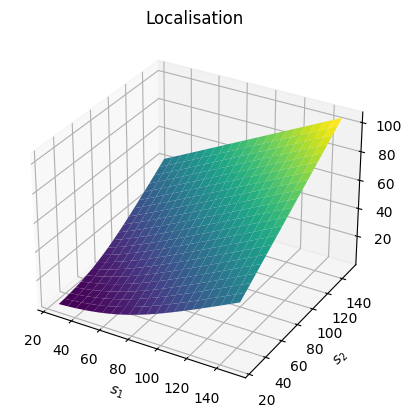

In [76]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, localisation_plot, cmap='viridis')
ax.set_title('Localisation')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

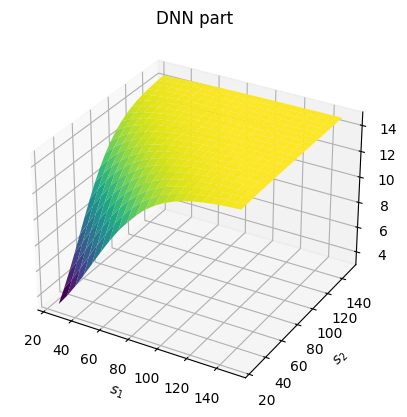

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

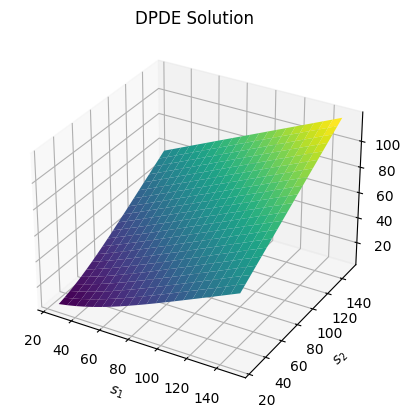

In [78]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

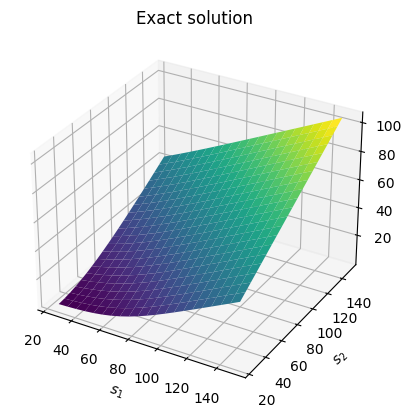

In [79]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, exact_solution_evaluated, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

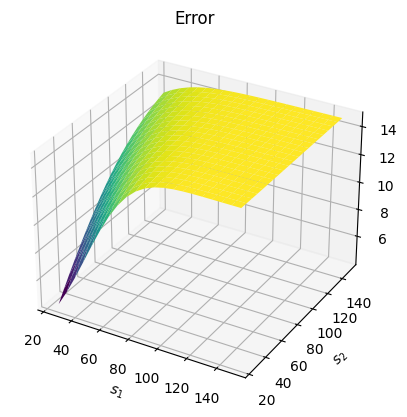

In [80]:
fifig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [81]:
Implied_Volatility_Explicit = [Implied_Volatility_bis(Price=exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval),S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_Explicit = np.array(Implied_Volatility_Explicit)
Implied_Volatility_Explicit = Implied_Volatility_Explicit.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

In [82]:
Implied_Volatility_DPDE = [Implied_Volatility_bis(Price=
                                              model.predict(np.array([normalise.normalise_time(t_max), normalise.normalise_logprice(np.log(s1[0])),
                                              normalise.normalise_logprice(np.log(s2[0])), normalise.normalise_riskfree_rate(riskfree_rate_eval), 
                                              normalise.normalise_volatility(volatility1_eval), normalise.normalise_volatility(volatility2_eval), 
                                              normalise.normalise_correlation(correlation_eval)]).reshape(1,7))[0][0]
                                              ,S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_DPDE = np.array(Implied_Volatility_DPDE)
Implied_Volatility_DPDE = Implied_Volatility_DPDE.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

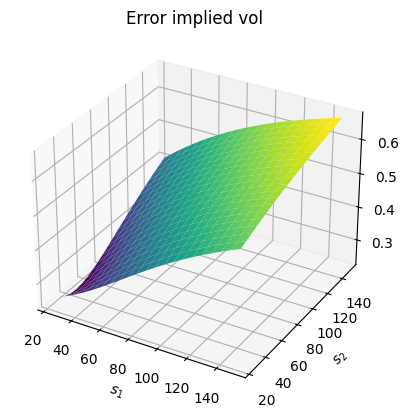

In [83]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(Implied_Volatility_DPDE - Implied_Volatility_Explicit)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error implied vol')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

Text(0, 0.5, 'DPDE Error')

<Figure size 1000x1000 with 0 Axes>

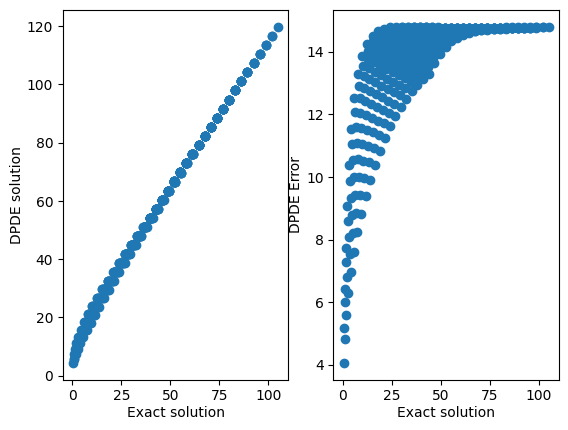

In [84]:
f = plt.figure(figsize=(10,10))    
f, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].scatter(exact_solution_evaluated, DPDE_solution)
axes[0].set_xlabel('Exact solution', labelpad = 2)
axes[0].set_ylabel('DPDE solution', labelpad = 2)


axes[1].scatter(exact_solution_evaluated, np.abs(exact_solution_evaluated - DPDE_solution))
axes[1].set_xlabel('Exact solution', labelpad = 2)
axes[1].set_ylabel('DPDE Error', labelpad = 2)

Text(0, 0.5, 'DPDE Relative Error')

<Figure size 1000x1000 with 0 Axes>

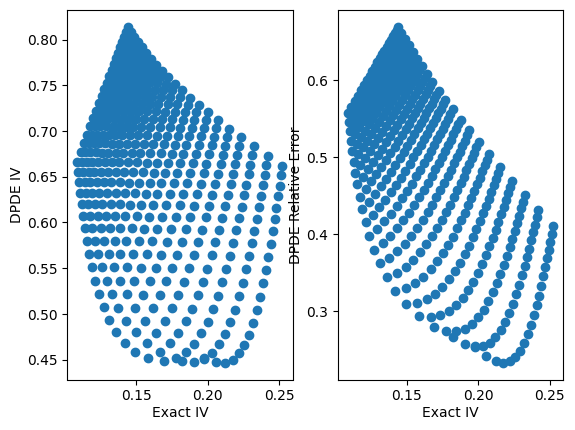

In [85]:
f = plt.figure(figsize=(10,10))    
f, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].scatter(Implied_Volatility_Explicit, Implied_Volatility_DPDE)
axes[0].set_xlabel('Exact IV', labelpad = 2)
axes[0].set_ylabel('DPDE IV', labelpad = 2)


axes[1].scatter(Implied_Volatility_Explicit, np.abs(Implied_Volatility_Explicit - Implied_Volatility_DPDE))
axes[1].set_xlabel('Exact IV', labelpad = 2)
axes[1].set_ylabel('DPDE Relative Error', labelpad = 2)